In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping

## Data Loading

In [3]:
df = pd.read_csv('RSCCASN.csv',parse_dates=True,index_col='DATE')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [7]:
df.columns = ['Sales']

In [8]:
df.head()

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


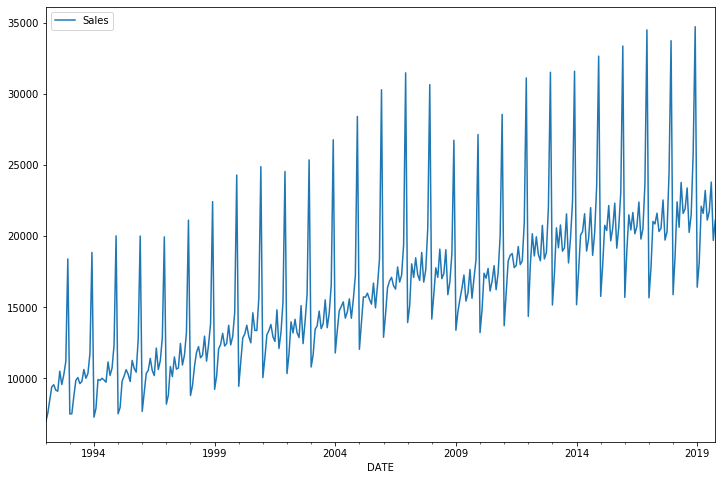

In [9]:
df.plot(figsize=(12,8))

## Train and Test Split

In [12]:
test_size = 18
test_index = len(df) - test_size
train = df.iloc[:test_index]
test = df.iloc[test_index:]

In [19]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [21]:
length = 12
generator = TimeseriesGenerator(scaled_train,scaled_train,
                                length=length,batch_size=1)

## Model

In [31]:
n_features = 1
model = Sequential()

model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [34]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

valid_generator = TimeseriesGenerator(scaled_test,scaled_test,
                                      length=length,batch_size=1)

In [35]:
model.fit_generator(generator,epochs=20,
                    validation_data=valid_generator,
                    callbacks=[early_stop])

Epoch 1/20
304/304 [==============================] - 15s 49ms/step - loss: 0.0253 - val_loss: 0.0040
Epoch 2/20
304/304 [==============================] - 13s 43ms/step - loss: 0.0183 - val_loss: 0.0085
Epoch 3/20
304/304 [==============================] - 13s 42ms/step - loss: 0.0123 - val_loss: 0.0039
Epoch 4/20
304/304 [==============================] - 13s 41ms/step - loss: 0.0040 - val_loss: 0.0027
Epoch 5/20
304/304 [==============================] - 14s 47ms/step - loss: 0.0020 - val_loss: 8.5710e-04
Epoch 6/20
304/304 [==============================] - 12s 41ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 7/20
304/304 [==============================] - 12s 41ms/step - loss: 0.0014 - val_loss: 3.1118e-04
Epoch 8/20
304/304 [==============================] - 12s 39ms/step - loss: 0.0014 - val_loss: 0.0052
Epoch 9/20
304/304 [==============================] - 12s 40ms/step - loss: 0.0016 - val_loss: 0.0025


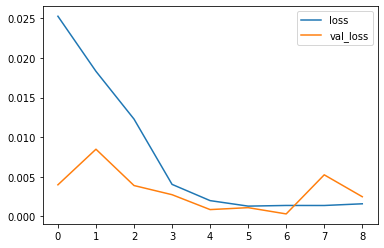

In [36]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [37]:
def test_pred(train_df,size,n_features,length):

    test_predictions = []
    first_eval_batch = train_df[-length:]
    current_batch = first_eval_batch.reshape((1,length,n_features))

    for i in range(size):

        pred = model.predict(current_batch)[0]
        test_predictions.append(pred)
        current_batch = np.append(current_batch[:,1:,:],[[pred]],axis=1)
    
    return test_predictions

In [38]:
test_predictions = test_pred(scaled_train,len(test),n_features,length)
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions

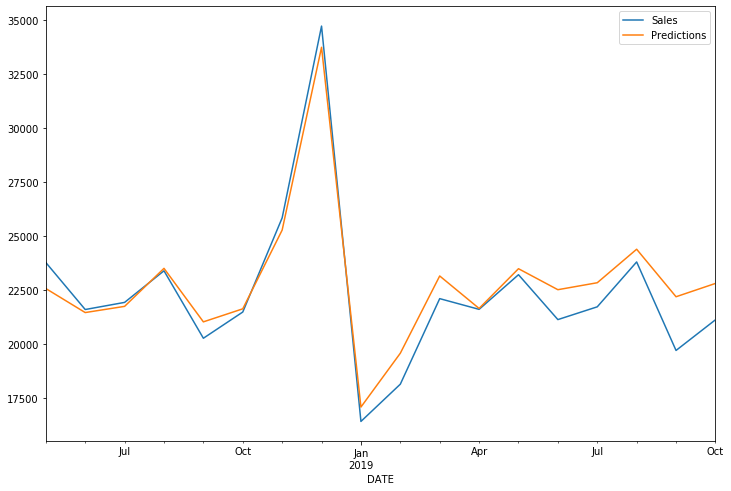

In [46]:
test.plot(figsize=(12,8))

## Future Forecasting

In [47]:
full_scaler = MinMaxScaler()
full_scaled_data = full_scaler.fit_transform(df)

In [49]:
length = 12
generator = TimeseriesGenerator(full_scaled_data,full_scaled_data,
                                length=length,batch_size=1)

In [50]:
model = Sequential()

model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

In [51]:
model.fit_generator(generator,epochs=6)

Epoch 1/6
322/322 [==============================] - 15s 47ms/step - loss: 0.0246
Epoch 2/6
322/322 [==============================] - 14s 43ms/step - loss: 0.0164
Epoch 3/6
322/322 [==============================] - 13s 41ms/step - loss: 0.0124
Epoch 4/6
322/322 [==============================] - 12s 38ms/step - loss: 0.0048
Epoch 5/6
322/322 [==============================] - 12s 37ms/step - loss: 0.0034
Epoch 6/6
322/322 [==============================] - 13s 41ms/step - loss: 0.0019


In [52]:
periods = 12
forecast = test_pred(full_scaled_data,periods,n_features,length)
forecast = full_scaler.inverse_transform(forecast)
forecast_index = pd.date_range(start='2019-11-01',periods=periods,
                               freq='MS')

In [63]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [64]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

(576, 611)

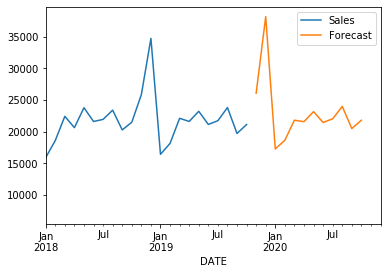

In [69]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')